# <font color='Blue'> $\;$ CCS in a fractured reservoir</font>

## Import all important packages

It includes two local files:
 * [Model](https://gitlab.com/open-darts/darts-models/-/blob/development/teaching/EAGE/model.py) with main model description
 * [Model_input](https://gitlab.com/open-darts/darts-models/-/blob/development/teaching/EAGE/model_input.py) with input parameters


In [41]:
import os
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt

from darts.engines import redirect_darts_output
from darts.tools.fracture_network.preprocessing_code import frac_preprocessing

from carbonate.model import Model
from carbonate.input_default import input_data_default

redirect_darts_output('model4.log')

C:\Users\smmohammadtagh\AppData\Local\miniconda3\envs\flash_release39\python.exe


## Set parameters

In [42]:

def input_data_case_1():
    idata = input_data_default()

    idata.geom['case_name'] = 'case_1'

    # geometry
    idata.geom['frac_file'] = os.path.join('carbonate', 'frac_1.txt')

    # do not use cleaned mesh
    #idata.geom['mesh_prefix'] = 'raw_lc'
    idata.geom['mesh_prefix'] = 'mergefac_0.86_clean_lc'  #  cleaned mesh
    idata.geom['mesh_clean'] = True 

    # cell sizes
    idata.geom['char_len'] = 20  # near fractures (characteristic length for cleaning and mesh generation) [m]
    idata.geom['char_len_boundary'] = 150  # grid size near grid boundaries [m]
    idata.geom['char_len_well'] = 10  # grid size near wells [m]

    # uniform initial pressure and temperature
    idata.initial.type ='uniform'
    idata.initial.initial_pressure = 250.  # bar
    idata.initial.initial_temperature = 350  # K

    # well locations
    idata.geom['inj_well_coords'] = [[200, 200, 25]]  # X, Y, Z (only one perforation)
    idata.geom['prod_well_coords'] = [[800, 800, 25]]

    # well in the matrix cells or in the fractures
    idata.geom['well_loc_type'] = 'wells_in_nearest_cell'

    # extrusion - number of layers by Z axis
    idata.geom['rsv_layers'] = 1

    idata.geom['z_top'] = 2000  # [m]
    idata.geom['height_res'] = 10  # [m]

    idata.geom['frac_aper'] = 1e-3  # (initial) fracture aperture [m]

    wctrl = idata.well_data.controls
    wctrl.delta_temp = 40  # inj_temp = initial_temp - delta_temp
    wctrl.delta_p_inj  = 20  # inj_bhp = initial_pressure + delta_p_inj
    wctrl.delta_p_prod = 20  # inj_prod = initial_pressure - delta_p_prod

    return idata

In [43]:
input_data = input_data_case_1()

## Plot Discrete Fractured Network (DFN)

In [44]:
def plot_dfn(input_data):
    frac_data_raw = np.genfromtxt(input_data.geom['frac_file'])

    plt.gca().set_aspect('equal')
    for i in range(frac_data_raw.shape[0]):
        plt.plot(np.append(frac_data_raw[i, 0], frac_data_raw[i, 2]),
                 np.append(frac_data_raw[i, 1], frac_data_raw[i, 3]))
    
    wells_inj = input_data.geom['inj_well_coords']
    plt.plot(wells_inj[0][0], wells_inj[0][1], 'o', color='b', label='inj well')
    wells_prod = input_data.geom['prod_well_coords']
    plt.plot(wells_prod[0][0], wells_prod[0][1], 'o', color='r', label='prod well')
    
    plt.xlabel('X, m.')
    plt.ylabel('Y, m.')
    plt.legend()
    plt.grid()
    plt.show()

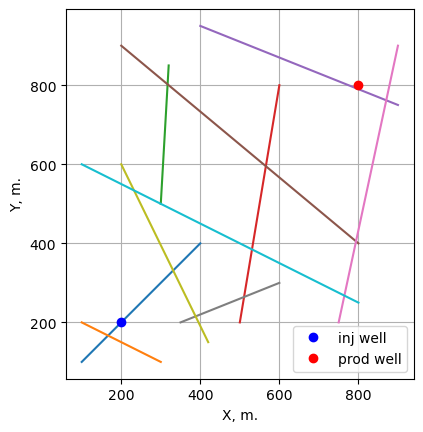

In [45]:
plot_dfn(input_data)

## Mesh generation

For details on DFN mesh generation and parameters see https://doi.org/10.1029/2021WR030743.

In [46]:
# Read fracture tips from input_data['frac_file'] and generate a .geo text file (input for gmsh), then
# call gmesh to create a mesh and output it to .msh text file, which will be used as an input to DARTS
# These files are stored tin the 'meshes' folder, one mesh is original (raw) 
# and the second is optimized for calculation (cleaned)

def generate_mesh(idata):
    case_name = idata.geom['case_name']
    print('case', case_name)
    output_dir = 'meshes_' + case_name
    
    frac_data_raw = np.genfromtxt(input_data.geom['frac_file'])

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Input parameters for cleaning procedure
    angle_tol_straighten = 7.5  # tolerance for straightening fracture segments [degrees]
    merge_threshold = 0.86  # tolerance for merging nodes in algebraic constraint, values on interval [0.5, 0.86] [-]
    angle_tol_remove_segm = np.arctan(0.35) * 180 / np.pi   # tolerance for removing accute intersections, values on interval [15, 25] [degrees]
    decimals = 7  # in order to remove duplicates we need to have fixed number of decimals
    mesh_raw = True#False  # need gmsh installed and callable from command line in order to mesh!!!
    num_partition_x = 4  # number of partitions for parallel implementation of intersection finding algorithm
    num_partition_y = 4  # " ... "

    frac_preprocessing(frac_data_raw, char_len=idata.geom['char_len'], output_dir=output_dir, filename_base=idata.geom['case_name'], merge_threshold=merge_threshold, z_top=idata.geom['z_top'],
                       height_res=idata.geom['height_res'], angle_tol_small_intersect=angle_tol_remove_segm, apertures_raw=None, box_data=idata.geom['box_data'], margin=idata.geom['margin'],
                       mesh_clean=idata.geom['mesh_clean'], mesh_raw=mesh_raw, angle_tol_straighten=angle_tol_straighten, straighten_after_cln=True, decimals=decimals,
                       tolerance_zero=1e-10, tolerance_intersect=1e-10, calc_intersections_before=False, calc_intersections_after=False,
                       num_partition_x=num_partition_x, num_partition_y=num_partition_y, partition_fractures_in_segms=True, matrix_perm=1, correct_aperture=False,
                       small_angle_iter=2, char_len_mult=1, char_len_boundary=idata.geom['char_len_boundary'], main_algo_iters=1,
                       wells=None,#idata.geom['inj_well_coords']+idata.geom['prod_well_coords'],
                       char_len_well=idata.geom['char_len_well'], input_data=idata.geom)

In [47]:
# need gmsh installed and callable from command line in order to mesh or gmsh python package installed
generate_mesh(input_data)

case case_1
--------------------------------------
START preprocessing fracture network
Remove segments of zero length and duplicate segments
Number of fracture segments: 10
Min fracture segment length: 223.60679774997897
Max fracture segment length: 782.6237921249264
Mean fracture segment length: 519.4931807755204
Cleaning length(s): 20

Remove duplicated segments

START constructing graph
DONE constructing graph

START main cleaning loop for l_f=20
DONE main cleaning loop for l_f=20

START writing clean fracture system to file
DONE writing clean fracture system to file

START creating geo-file for cleaned network (input for gmsh)
DONE creating geo-file for cleaned network (input for gmsh)

START meshing cleaned network
	NOTE: In gmsh you need to have under Options -> Geometry -> General -> uncheck "Remove duplicate ..." otherwise meshing will crash/take too long
	      Click File -> "Save options and default" in gmsh to save the setting.
Gmsh output is written to the file meshes_case

## Run simulation

In [48]:
m = Model(input_data)
m.set_sim_params(first_ts=1e-2, mult_ts=2, max_ts=60, tol_newton=1e-3, tol_linear=1e-4, it_newton=10, it_linear=50)
m.init()
m.set_output(output_folder='output/carbonate')

# output initial solution to vtk file
output_dir = m.output_folder + '/vtk_output_dfn'
m.data_ts.dt_first = 1e-5
m.data_ts.eta = [1, 0.02]

# plot relative permeability and capillary pressure curves of 'fractured' and 'matrix' cells
m.plot_rel_perms() 

output_props = m.physics.vars + m.output.properties
m.output.output_to_vtk(ith_step = 0, output_properties = output_props, engine = True)

# run simulation for 365 days
for i in range(1):
    m.run(365)
    
    # output current timestep to vtk file
    m.output.output_to_vtk(ith_step = i + 1, output_properties = output_props, engine = True)

darts-package built on 03/07/2025 20:22:25 by SRV554$@SRV554 from f18e70b9

Discretize...
Start loading mesh...

Time to load Mesh: 0.072382 [sec]
Total number of matrix cells found: 3718
Total number of fracture cells found: 284
Total number of boundary faces found: 7464
Total number of fracture boundary faces found: 0
Total number of output faces found: 0
<meshio mesh object>
  Number of points: 3748
  Number of cells:
    triangle: 3718
    quad: 7
    quad: 7
    quad: 7
    quad: 7
    triangle: 3718
    quad: 8
    quad: 1
    quad: 4
    quad: 14
    quad: 14
    quad: 2
    quad: 7
    quad: 1
    quad: 17
    quad: 15
    quad: 1
    quad: 4
    quad: 6
    quad: 2
    quad: 2
    quad: 17
    quad: 7
    quad: 4
    quad: 2
    quad: 6
    quad: 11
    quad: 2
    quad: 10
    quad: 26
    quad: 2
    quad: 2
    quad: 2
    quad: 1
    quad: 11
    quad: 7
    quad: 4
    quad: 17
    quad: 5
    quad: 1
    quad: 13
    quad: 2
    quad: 2
    quad: 1
    quad: 2
    quad: 

KeyboardInterrupt: 

## Plot well rates

In [40]:
# postprocessing
td = m.output.store_well_time_data() # by default, compute all types of rates 

# save time data as a .pkl and .xlsx file
time_data_df = pd.DataFrame(td)
time_data_df['Time (years)'] = time_data_df['time']/365.
time_data_df.to_pickle(os.path.join(m.output_folder, 'well_time_data.pkl'))
with pd.ExcelWriter(os.path.join(m.output_folder, 'well_time_data.xlsx')) as w:
    time_data_df.to_excel(w, sheet_name='Sheet1')

# output all available columns to m.output_folder/figures/... 
m.output.plot_well_time_data() 

print(time_data_df.keys()) # print keys to see available columns in time_data
time_data_df.plot(x = 'Time (years)', y = ['well_P1_mass_rate_CO2_by_sum_perfs'])
plt.xlabel('kg/day')
plt.ylabel('Time - year')
plt.grid(True)
plt.show()

PermissionError: [WinError 5] Access is denied: 'output/carbonate\\figures/well_time_plots\\well_I1\\perf_0'

## Plot gas saturation map

In [20]:
def plot_pyvista(input_data, output_dir):
    import pyvista as pv

    vtk_fname = os.path.join(output_dir, 'solution_ts1.vtu')

    # get vts data
    mesh = pv.read(vtk_fname)

    # define plotter
    plotter = pv.Plotter()

    # set temperature as active scalar
    temp = mesh.set_active_scalars('satV')

    # add threshold levels
    thresT = mesh.threshold([0, 1], invert=False)
    
    # set fracture as active scalar
    mesh.set_active_scalars('matrix_cell_bool')
    # plot only fractures (0 index)
    thresF = mesh.threshold([0, 0], invert=False)
    # add outline of mesh
    outline = mesh.outline()

    # add elements to plotter
    plotter.set_background('#52576c')
    plotter.add_mesh(outline, color='k')
    try: # in case there is an issue in PyVista "'NoneType' object is not callable"
        plotter.add_mesh(thresT, cmap='coolwarm', opacity=0.99,
                     scalar_bar_args={'title':'GAS SATURATION'})
        plotter.add_mesh(thresF, show_scalar_bar=False, cmap='coolwarm')
    except:
        plotter.add_mesh(thresT, opacity=0.99,
                     scalar_bar_args={'title':'Temperature (\N{DEGREE SIGN}C)'})
        plotter.add_mesh(thresF, show_scalar_bar=False)
    
    # add wells as lines
    wells_inj = input_data.geom['inj_well_coords']
    wells_prod = input_data.geom['prod_well_coords']

    i = 0

    injline = np.array([[wells_inj[i][0], wells_inj[i][1], 2000], [wells_inj[i][0], wells_inj[i][1], 2200]])
    prodline = np.array([[wells_prod[i][0], wells_prod[i][1], 2000], [wells_prod[i][0], wells_prod[i][1], 2200]])

    plotter.add_lines(injline, color='b', name='injector')
    plotter.add_lines(prodline, color='r', name='producer')
    plotter.add_axes(line_width=5, labels_off=False)
    plotter.camera_position = [-2,-5,3] 
    plotter.camera.zoom(1.3)
    
    plotter.show()

C:\Users\smmohammadtagh\AppData\Local\miniconda3\envs\flash_release39\lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


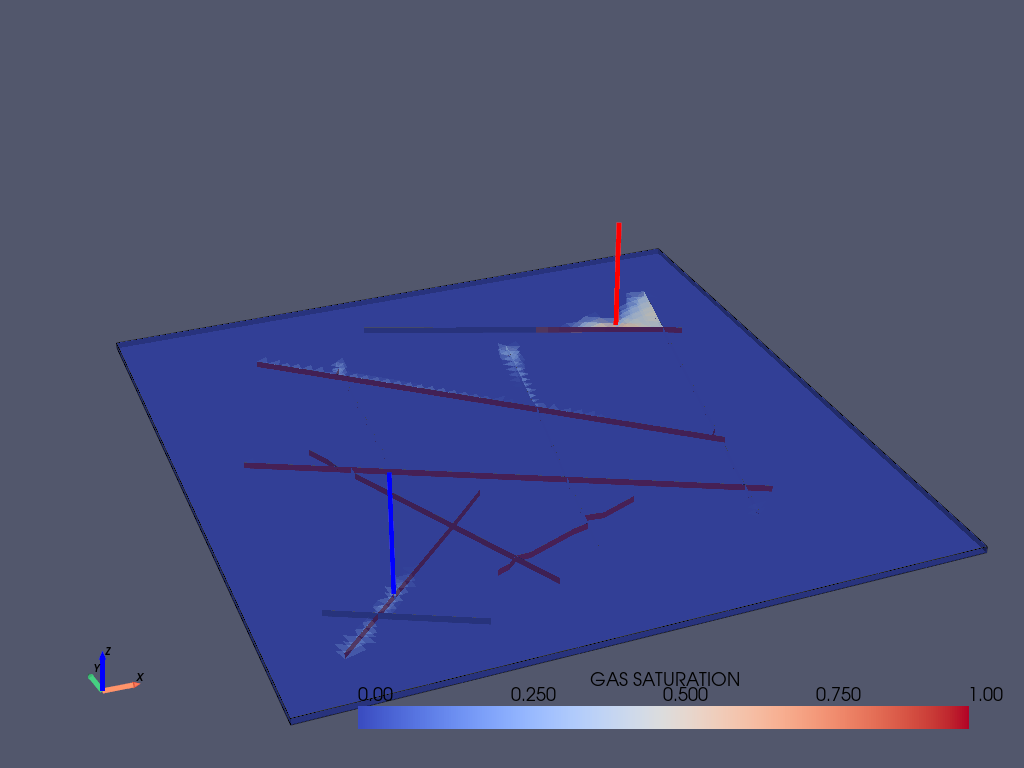

In [21]:
import os 
output_dir = os.path.join(m.output_folder, 'vtk_files') # location of the *.vtk files 
plot_pyvista(input_data, output_dir) # please ensure pyvsita module is installed to your environment for this. 

## <font color='Blue'>Tasks in this workshop:</font>

Plot and copy production temperature and rates after each task items:

1. Run simulation for 10 years and compare well output and gas saturation maps
2. Change the reservoir thickness to 100 m and compare well output 
3. Change matrix permeability to granite (0.01 mD) and compare well output
4. Change matrix permeability to sandstone (100 mD) and compare well output

More details on modeling of geothermal energy production in fractured reservoirs can be found in https://doi.org/10.1016/j.advwatres.2021.103985 